USA's political partisanship problem, lamented for a long time, affects the country citizens in unpredictable ways - a recent [study](https://www.vox.com/science-and-health/2020/3/31/21199271/coronavirus-in-us-trump-republicans-democrats-survey-epistemic-crisis) suggests the level of partisanship is the strongest predictor for coronavirus response. But how to gauge the gravity of this issue emprically? Inspired by Professor Elliot Ash (see his related work [here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3205116)), whose workshop I attended during [POLTEXT conference](http://www.comptextconference.org/2nd-annual-poltext-conference-2019/) in September 2019, I attempted predicting political affiliation of users included in 2008-2017 US Congressional Tweets Dataset (Senators, Governors and one President) based on metrics engineered from their tweets. One of the most interesting challenges of this project was the lack of affiliation information in the data - this had to be scraped from Wikipedia. I managed to achieve best results through training a logistic regression classifier with accuracy above 80% for both train and test sets on a matrix of tf-idf-weighted bigrams and unigrams of the users' tweet texts. This high accuracy of prediction based only on the text of tweets suggest that at least within the platform, the level of partisanship is high.

# __Project's aim__:


> *Attempting to predict a politician's affiliation based on her tweets*


> *High accuracy of such prediction will suggest high levels of polarization of American politics*





## Data Exploration

In [3]:
#mouting drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
%cd "/content/drive/My Drive/datasets"

/content/drive/My Drive/datasets


In [10]:
#installing libraries not supported by Google Colab
%pip install mediawiki
%pip install wikipedia

  Created wheel for wikipedia: filename=wikipedia-1.4.0-cp36-none-any.whl size=11686 sha256=e36a96052e333b809d6d1e57236a61055242017536b5421f7f56241f3d964fb4
  Stored in directory: /root/.cache/pip/wheels/87/2a/18/4e471fd96d12114d16fe4a446d00c3b38fb9efcb744bd31f4a
Successfully built wikipedia


In [0]:
#importing libraries necessary for the exploratory analysis
import pandas as pd
import wikipedia
import spacy
import en_core_web_sm
from pprint import pprint
nlp = en_core_web_sm.load()

In [0]:
#reading first table - users
df = pd.read_csv("usersjoined.csv")

In [13]:
df.head()

,id,screen_name,name,description,followers,follows,joined,tweet_count
0,787373558,RepCummings,Elijah E. Cummings,U.S. Representative from Maryland's 7th Distri...,104521,1611,2012-08-28 16:37:01,3231.0
1,798973032362606600,RepValDemings,Rep. Val Demings,U.S. Representative Florida's 10th Congression...,3498,180,2016-11-16 19:36:29,689.0
2,237814920,RepHultgren,Rep. Randy Hultgren,Member of Congress proudly representing IL-14....,14074,1859,2011-01-13 18:03:42,3226.0
3,1064206014,TulsiPress,Rep. Tulsi Gabbard,Aloha - Official account of Rep Tulsi Gabbard ...,72270,1125,2013-01-05 22:57:50,2593.0
4,72198806,SenGillibrand,Kirsten Gillibrand,"Theo and Henry's mom, U.S. Senator from New Yo...",396587,488,2009-09-07 03:53:24,3210.0


###Scraping party affiliation of politicians from Wikipedia

In [14]:
#there are two main challenges with the data at this stage: not many users include
#their political affiliation in the description, but many add titles such as 
#"Rep." to their name. To perform scraping in order to define political affiliation,
#we first need to clean up users' names.
def spacy_name_clean(some_string):
    """Remove up titles (governor, representative) from strings"""
    tagged_str = nlp(some_string)
    namelist = [X.text for X in tagged_str.ents if X.label_ == 'PERSON']
    if len(namelist) >= 1:
        name = namelist[0]
    else:
        name = some_string
    return name

#testing if it works
clean_name = spacy_name_clean("Rep. Val Demings")
print(clean_name)

Val Demings


In [0]:
#applying the function on the dataframe
df["cleaned_names"] = df.name.apply(spacy_name_clean)

In [17]:
df.head()

,id,screen_name,name,description,followers,follows,joined,tweet_count,cleaned_names
0,787373558,RepCummings,Elijah E. Cummings,U.S. Representative from Maryland's 7th Distri...,104521,1611,2012-08-28 16:37:01,3231.0,Elijah E. Cummings
1,798973032362606600,RepValDemings,Rep. Val Demings,U.S. Representative Florida's 10th Congression...,3498,180,2016-11-16 19:36:29,689.0,Val Demings
2,237814920,RepHultgren,Rep. Randy Hultgren,Member of Congress proudly representing IL-14....,14074,1859,2011-01-13 18:03:42,3226.0,Randy Hultgren
3,1064206014,TulsiPress,Rep. Tulsi Gabbard,Aloha - Official account of Rep Tulsi Gabbard ...,72270,1125,2013-01-05 22:57:50,2593.0,Tulsi Gabbard
4,72198806,SenGillibrand,Kirsten Gillibrand,"Theo and Henry's mom, U.S. Senator from New Yo...",396587,488,2009-09-07 03:53:24,3210.0,Kirsten Gillibrand


In [0]:
#importing libraries necessary to scrape wikipedia
from bs4 import BeautifulSoup
import urllib.request, urllib.parse, urllib.error
from mediawiki import MediaWiki
import ssl
import re


ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

In [0]:
def polit_affil_through_wiki(name):
    try:
        wikipedia = MediaWiki(user_agent = 'pyMediaWiki-User-Agent-String1')
        search_res = wikipedia.search(name)
        result = search_res[0]
        page = wikipedia.page(result)
        url = page.url
        
        html = urllib.request.urlopen(url, context=ctx).read()
        soup = BeautifulSoup(html, 'lxml')
        
        my_table = soup.find('table', {'class':'infobox vcard'})
        res = re.findall(r'Political party</th>.+?\">(.+?)</a></td></tr><tr><th scope?', str(my_table))
        likely_res = res[0]
        if len(likely_res) > 10:
            text = likely_res.split("</a>")
            likely_res = text[0]
        return likely_res
    except:
        return np.nan

In [0]:
#checking if it works
polit_affil_through_wiki("Jerry Seinfeld")

nan

In [0]:
df["likely_affiliation"] = df.cleaned_names.apply(polit_affil_through_wiki)

In [0]:
#checking how many times scraping failed
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 10 columns):
id                    548 non-null int64
screen_name           548 non-null object
name                  548 non-null object
description           539 non-null object
followers             548 non-null int64
follows               548 non-null int64
joined                545 non-null object
tweet_count           545 non-null float64
cleaned_names         548 non-null object
likely_affiliation    472 non-null object
dtypes: float64(1), int64(3), object(6)
memory usage: 42.9+ KB


In [0]:
noaffil = df[df.likely_affiliation.isna()]

In [0]:
noaffil[noaffil.name.str.contains("U.S.Rep Gonzalez")]

,id,screen_name,name,description,followers,follows,joined,tweet_count,cleaned_names,likely_affiliation
450,818536152588238849,RepGonzalez,U.S.Rep Gonzalez,"Representing the 15th District of Texas in US Congress, public servant, man of the people, lawyer, friend, business owner. #TX15GettingItRight",437,10,2017-01-09 19:13:21,16.0,Gonzalez,NaN


In [0]:
#these names have to be inserted manually
list_for_input = noaffil.name

In [0]:
names_to_aff = {}

In [0]:
for item in list_for_input:
    inputres = input(item)
    if inputres == "r":
        party = "Republican"
    elif inputres == "d":
        party = "Democratic"
    else:
        party = "Independent"
    names_to_aff[item] = party

In [0]:
names_to_aff

In [0]:
names_to_aff['U.S.Rep Gonzalez'] = 'Democratic'

In [0]:
#mapping the created dictionary to the existing dataframe
df_cp = df.copy(deep=True)

In [0]:
df_cp.set_index(df_cp.name, inplace = True)

In [0]:
not_na = df_cp.loc[~df_cp.likely_affiliation.isna()]

In [0]:
aff_dict = not_na.likely_affiliation.to_dict()

In [0]:
aff_dict.update(names_to_aff)

In [0]:
len(aff_dict.keys()) == df_cp.shape[0]

True

In [0]:
df_cp['probable_affiliation'] = df_cp.index.map(aff_dict)

In [0]:
df_cp = df_cp.drop('likely_affiliation', axis = 1)

In [0]:
#checking the results
df_cp.probable_affiliation.value_counts()

Republican     302
Democratic     244
Independent    1  
Federalist     1  
Name: probable_affiliation, dtype: int64

In [0]:
#it appears we got the wrong Daniel Webster
df_cp.loc[df_cp.probable_affiliation=="Federalist"]

,id,screen_name,name,description,followers,follows,joined,tweet_count,cleaned_names,probable_affiliation
name,,,,,,,,,,
Daniel Webster,281540744,RepWebster,Daniel Webster,A family man and small-business owner who is dedicated to serving the citizens of Central Florida with honor and integrity.,14057,267,2011-04-13 13:47:05,2939.0,Daniel Webster,Federalist


In [0]:
df_cp.loc["Daniel Webster", "probable_affiliation"] = "Republican"

In [0]:
df_cp.probable_affiliation.value_counts()

Republican     303
Democratic     244
Independent    1  
Name: probable_affiliation, dtype: int64

In [0]:
#saving the results
df_cp.to_csv('with_affiliation.csv')

In [0]:
test = pd.read_csv("with_affiliation.csv", index_col = 0)

In [21]:
test.head()

,id,screen_name,description,followers,follows,joined,tweet_count,cleaned_names,probable_affiliation
name,,,,,,,,,
Elijah E. Cummings,787373558,RepCummings,U.S. Representative from Maryland's 7th Distri...,104521,1611,2012-08-28 16:37:01,3231.0,Elijah E. Cummings,Democratic
Rep. Val Demings,798973032362606600,RepValDemings,U.S. Representative Florida's 10th Congression...,3498,180,2016-11-16 19:36:29,689.0,Val Demings,Democratic
Rep. Randy Hultgren,237814920,RepHultgren,Member of Congress proudly representing IL-14....,14074,1859,2011-01-13 18:03:42,3226.0,Randy Hultgren,Republican
Rep. Tulsi Gabbard,1064206014,TulsiPress,Aloha - Official account of Rep Tulsi Gabbard ...,72270,1125,2013-01-05 22:57:50,2593.0,Tulsi Gabbard,Democratic
Kirsten Gillibrand,72198806,SenGillibrand,"Theo and Henry's mom, U.S. Senator from New Yo...",396587,488,2009-09-07 03:53:24,3210.0,Kirsten Gillibrand,Democratic


## Visual exploration of the dataset

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
df = pd.read_csv("with_affiliation.csv")

In [25]:
#checking the data
df.probable_affiliation.value_counts()

Republican     303
Democratic     244
Independent      1
Name: probable_affiliation, dtype: int64

In [0]:
#dropping the user whose affiliation is not Republican or Democratic 
df = df.loc[df.probable_affiliation != "Independent"]

In [27]:
df.probable_affiliation.value_counts()

Republican    303
Democratic    244
Name: probable_affiliation, dtype: int64

In [0]:
df["probable_affiliation"] = df.probable_affiliation.map({"Republican":1, "Democratic":0})

In [0]:
pd.set_option("display.precision", 2)

### Exploring follower count


In [30]:
#getting some descriptive statistics
print("Average followers: ", df.followers.mean())
print("Max followers:", df.followers.max())
print("User with max followers", df.loc[df.followers == df.followers.max(), "name"])
print("Min followers:", df.followers.min())
print("User with min followers", df.loc[df.followers == df.followers.min(), "name"])
print("Standard deviation", df.followers.std())

Average followers:  163657.02925045704
Max followers: 31712585
User with max followers 478    Donald J. Trump
Name: name, dtype: object
Min followers: 4
User with min followers 141    Jasmine Coleman
Name: name, dtype: object
Standard deviation 1598810.5860084195


### Exploring follower count by party

In [31]:
df_rep = df.loc[df.probable_affiliation == 1]
print(df_rep.shape[0])
df_dem = df.loc[df.probable_affiliation ==0]
print(df_dem.shape[0])

303
244


In [32]:
#Republicans
print("Average followers: ", df_rep.followers.mean())
print("Max followers:", df_rep.followers.max())
print("User with max followers", df_rep.loc[df_rep.followers == df_rep.followers.max(), "name"])
print("Min followers:", df_rep.followers.min())
print("User with min followers", df_rep.loc[df_rep.followers == df_rep.followers.min(), "name"])
print("Standard deviation", df_rep.followers.std())

Average followers:  217756.65346534652
Max followers: 31712585
User with max followers 478    Donald J. Trump
Name: name, dtype: object
Min followers: 4
User with min followers 141    Jasmine Coleman
Name: name, dtype: object
Standard deviation 2114475.9054823513


In [38]:
#democrats
print("Average followers: ", df_dem.followers.mean())
print("Max followers:", df_dem.followers.max())
print("User with max followers", df_dem.loc[df_dem.followers == df_dem.followers.max(), "name"])
print("Min followers:", df_dem.followers.min())
print("User with min followers", df_dem.loc[df_dem.followers == df_dem.followers.min(), "name"])
print("Standard deviation", df_dem.followers.std())

Average followers:  96475.93852459016
Max followers: 5072538
User with max followers 407    Bernie Sanders
Name: name, dtype: object
Min followers: 41
User with min followers 496    Yvette Clarke
Name: name, dtype: object
Standard deviation 422855.5147283347


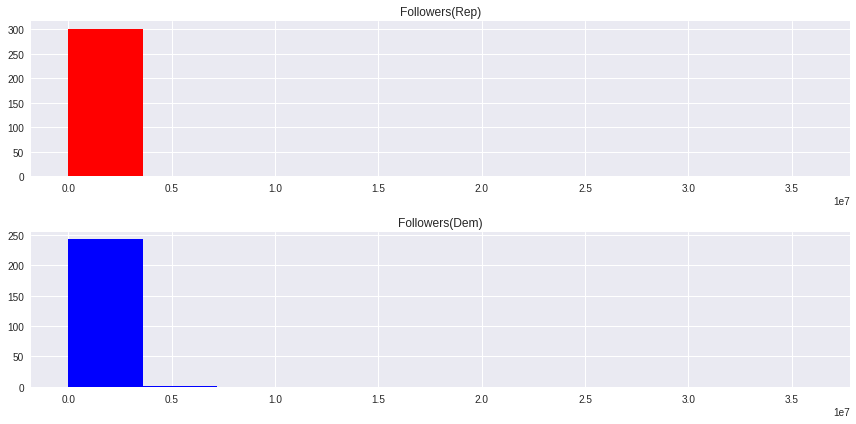

In [39]:
#plotting the follower distribution by user
fig, axs = plt.subplots(2,1, figsize = (12,6))
fig = df_rep.followers.hist(color = "r", range = (0, 36000000), ax = axs[0])
axs[0].set_title("Followers(Rep)")
fig = df_dem.followers.hist(color = "b", range = (0, 36000000), ax = axs[1])
axs[1].set_title("Followers(Dem)")
plt.tight_layout()

In [0]:
#removing outliers
dem_followers_no_outl = df_dem.loc[df_dem.followers.between(df_dem.followers.quantile(.15), 
                                                            df_dem.followers.quantile(.85)), 
                                                            "followers"]

In [0]:
rep_followers_no_outl = df_rep.loc[df_rep.followers.between(df_rep.followers.quantile(.15), 
                                                            df_rep.followers.quantile(.85)),
                                                            "followers"]

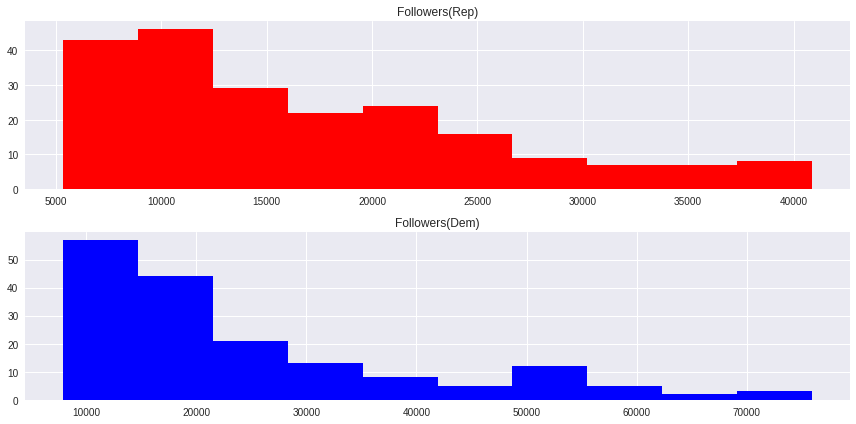

In [42]:
fig, axs = plt.subplots(2,1, figsize = (12,6))
fig = rep_followers_no_outl.hist(color = "r", ax = axs[0])
axs[0].set_title("Followers(Rep)")
fig = dem_followers_no_outl.hist(color = "b", ax = axs[1])
axs[1].set_title("Followers(Dem)")
plt.tight_layout()

_Observation_: As distributions of followers for both parties are right-scewed due to some outliers with unusually high amount of followers, this might not be the most helpful metric to look at.

## EXPLORING TWEETS

We now look at differences at the number of tweets created.

In [0]:
#reading the tweets table
df = pd.read_csv("with_dt_aff.csv", names = ["id", "created_at", "user_id", "probable_affiliation"])

In [66]:
df.head()

,id,created_at,user_id,probable_affiliation
0,877418565,2008-08-04 17:28:51,5558312,1.0
1,879618172,2008-08-06 19:04:45,5558312,1.0
2,879695803,2008-08-06 20:35:36,5558312,1.0
3,880393665,2008-08-07 13:52:52,5558312,1.0
4,880474266,2008-08-07 15:12:05,5558312,1.0


In [0]:
#separating republican and democratic tweets

In [0]:
rep_tweets = df.loc[df.probable_affiliation == 1].copy()

In [0]:
dem_tweets = df.loc[df.probable_affiliation == 0].copy()

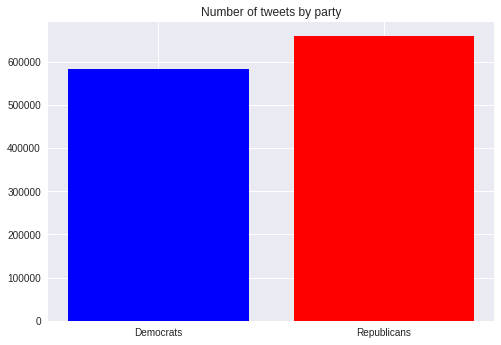

In [70]:
plt.bar(["Democrats", "Republicans"], df.groupby("probable_affiliation").count().id, color=("blue", "r"))
plt.title("Number of tweets by party")
plt.show()

# EXPLORING DISTRIBUTION OF TWEETS BY USER

In [0]:
#grouping tweets by user id
dem_tweets_by_user = dem_tweets.groupby("user_id").count().id

In [0]:
rep_tweets_by_user = rep_tweets.groupby("user_id").count().id

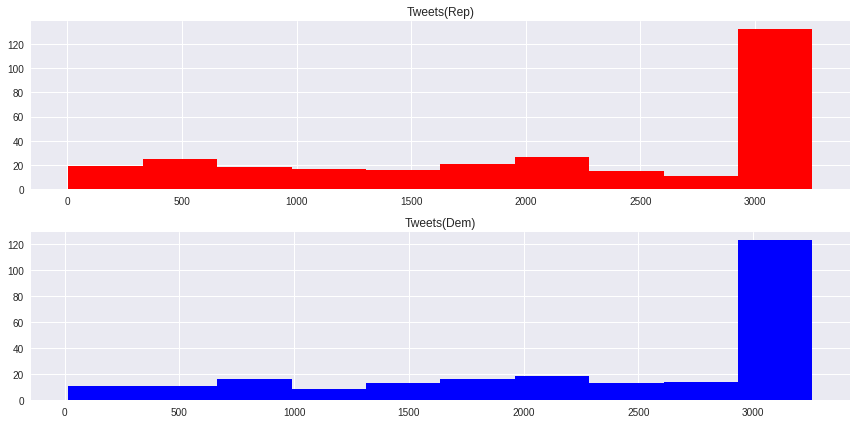

In [73]:
fig, axs = plt.subplots(2,1, figsize = (12,6))
fig = rep_tweets_by_user.hist(color = "r", ax = axs[0])
axs[0].set_title("Tweets(Rep)")
fig = dem_tweets_by_user.hist(color = "b", ax = axs[1])
axs[1].set_title("Tweets(Dem)")
plt.tight_layout()

In [0]:
#looking at differences by the time of sending the tweet
def data_toplot_time_tweeted(d):
    d["created_at"] = pd.to_datetime(d.created_at)
    by_hour = d.groupby(d.created_at.dt.hour).count()
    return by_hour.id

In [0]:
all_hours = data_toplot_time_tweeted(df)
rep_hours = data_toplot_time_tweeted(rep_tweets)
dem_hours = data_toplot_time_tweeted(dem_tweets)

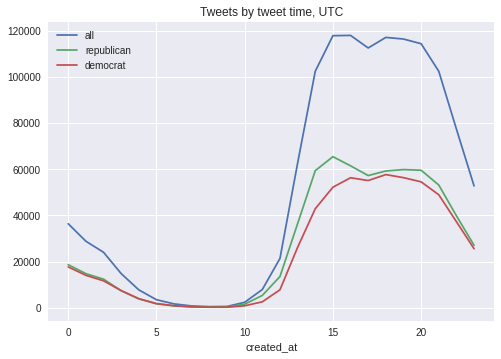

In [80]:
fig4 = plt.figure()
tweet_date_plot = all_hours.plot(label = "all")
tweet_date_plot.plot(rep_hours, label = "republican")
tweet_date_plot.plot(dem_hours, label = "democrat")
tweet_date_plot.legend()
tweet_date_plot.set_title("Tweets by tweet time, UTC")
plt.show()

_Observation_ : Exploration of non-textual elements of the dataset (number of followers, tweets, time of tweeting) does not show significant or informative differences between the two parties. We proceed to explore the text of tweets.

## Exploring the text of tweets

In [82]:
#installing libraries not included in google colab
%pip install emoji

     |████████████████████████████████| 51kB 1.9MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=bf80466b0db565d18ed4659772669bf1d81e075d000abe761976bdfadb47ac73
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji


In [83]:
#import necessary libraries
import emoji
import regex
import collections
import re  
import nltk 
nltk.download('stopwords')  
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
df = pd.read_json("with_aff.json",lines = True)

In [0]:
df = df.set_index("id")

In [0]:
#checking the information about the table
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1243370 entries, 877418565 to 872140026737336320
Data columns (total 3 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   text                  1243370 non-null  object 
 1   user_id               1243370 non-null  int64  
 2   probable_affiliation  1240590 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 37.9+ MB


In [86]:
df.probable_affiliation.value_counts()

1.0    658926
0.0    581664
Name: probable_affiliation, dtype: int64

In [0]:
#dropping tweets from users whose affiliation was 'independent'
df = df.dropna(axis = 0, how = "any")

In [0]:
df["text_len"] = df.apply(lambda x: len(x.text),axis =1)

In [91]:
#looking at the length of the text (0 for democrates, 1 for republicans)
df.groupby("probable_affiliation").mean().text_len

probable_affiliation
0.0    126.08
1.0    121.54
Name: text_len, dtype: float64

_Observation_: Democrat's tweets are 5 characters longer on average. Next, we will look at another metric that would be lost after the cleaning of the texts: who uses more emoji.

In [0]:
#a string to text the emoji-detecting function
mytext = "In the shadows 👩🏾‍🎓 of the #ComeyHearing, @HouseGOP plans to let Wall Street banks take the same risks that led to the 2008 financial crisis.🤦‍♂️ https://t.co/GsVMk9Q9Xp"

In [99]:
def emojilist(text):
  """A function that returns a list of emoji used in a text"""
  emoji_list = []
  data = regex.findall(r'\X', text)
  for word in data:
      if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)
  return emoji_list
split_count(mytext)

['👩🏾\u200d🎓', '🤦\u200d♂️']

In [0]:
#applying the function on the dataframe
df["emoji"] = df.apply(lambda x: emojilist(x.text), axis = 1)

In [0]:
#let's get the list of the emoji used and count them to see the emoji most commonly used
used_emoji = df.loc[df.emoji.str.len() > 0]

In [0]:
emoji = [emoji for lists in used_emoji.emoji for emoji in lists]

In [0]:
emoji_counter = collections.Counter()

In [0]:
emoji_counter.update(emoji)

In [110]:
sorted_dic = {k: v for k, v in sorted(emoji_counter.items(), key=lambda item: item[1], reverse = True)}
print(list(sorted_dic.keys())[:5])
print(list(sorted_dic.values())[:5])
#5 most-used emoji include phone and the US flag (the most used emoji)

['🇺🇸', '➡️', '✅', '❌', '📱']
[1896, 533, 440, 283, 277]


In [0]:
#adding a metric of the number of emoji used in a tweet
df["num_emoji"] = df.emoji.str.len()

In [116]:
#looking at the metric by the political party
df.groupby("probable_affiliation").sum().num_emoji

probable_affiliation
0.0    7450.0
1.0    6353.0
Name: num_emoji, dtype: float64

_Observation_: adding an emoji appears to be an unusual behaviour for US politicians, but democrats do it a little more often. Overall, non-textual metrics do not seem very informative. We proceed now to the exploration of text of tweets, first cleaning them.

In [0]:
#removing links
df["cleaned_text"] = df.text.str.replace("(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*", "")

In [0]:
#remove special characters
df["cleaned_text"] = df.cleaned_text.str.replace('\W', ' ', regex=True)

In [0]:
#remove single characters
df["cleaned_text"] = df.cleaned_text.str.replace('\s[A-Za-z]\s', ' ', regex=True)

In [0]:
#remove single characters from the start
df["cleaned_text"] = df.cleaned_text.str.replace('^[A-Za-z]\s', ' ', regex=True)

In [0]:
#remove single characters from the end
df["cleaned_text"] = df.cleaned_text.str.replace('\s[A-Za-z]$', ' ', regex=True)

In [0]:
#remove multiple spaces
df["cleaned_text"] = df.cleaned_text.str.replace('\s+', ' ', regex=True)

In [0]:
#remove numbers
df["cleaned_text"] = df.cleaned_text.str.replace('[0-9]*', '', regex=True)

In [0]:
#to lowercase
df["cleaned_text"] = df.cleaned_text.str.lower()

In [0]:
stops = stopwords.words('english')

In [0]:
#filtering out stopwords
df["text_non_stop_words"] = df.cleaned_text.apply(lambda x: [item.lower() for item in x.split() if item.lower() not in stops])

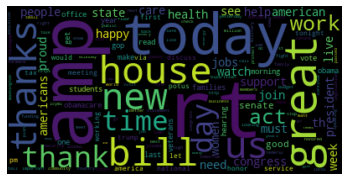

In [0]:
#looking at word clouds for all users and by party
from collections import Counter
from wordcloud import WordCloud

def calc_and_display_wc(df_ind):
    df = df_ind.copy()
    corpus = []
    for item_list in df.text_non_stop_words:
        corpus += item_list
    wordDict = Counter(corpus)
    wordcloud = WordCloud().generate_from_frequencies(wordDict)
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()
calc_and_display_wc(df)

In [0]:
dem_df = df.loc[df.probable_affiliation == 0].copy()

In [0]:
rep_df = df.loc[df.probable_affiliation == 1].copy()
#testing if dem/rep splitting went alright
dem_df.shape[0] + rep_df.shape[0] == df.shape[0] 

True

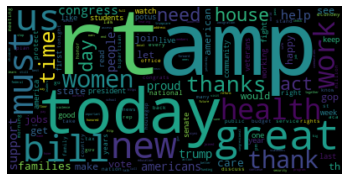

In [0]:
#democrats' wordcloud
calc_and_display_wc(dem_df)

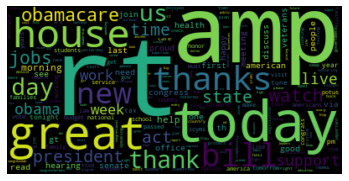

In [0]:
#republicans' wordcloud
calc_and_display_wc(rep_df)

_Observation_: Both Democrats and Republicans use the words "Great" and "Thank" a lot, Democrats talk often about Trump and Republicans about Obama. There is also a difference in how they talk about heathcare policy, with Democrats referring about "health" and Republicans about "Obamacare". In this way, we see some indications of political polarization, and proceed on evaluating polarization through textual characteristics of tweets, attempting logistic regression based on tf-idf-weighted bigram/uniram matrix. 

## Predicting political affiliation (tweetwise) by tf-idf weighted bigrams and unigrams 

In [0]:
#create a matrix of ngrams
#use idf weights, ngrams appearing in less than 100 tweets and more than 50%
#tweets are discarded
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', 
                             use_idf=True,                              
                             ngram_range=(1,2),    
                             min_df = 100,          
                             max_df = .5           
                             )

In [0]:
ngrams = vectorizer.fit_transform(df.cleaned_text)

In [0]:
ngrams

<1240590x17428 sparse matrix of type '<class 'numpy.float64'>'
	with 12757683 stored elements in Compressed Sparse Row format>

In [0]:
#importing necessary libraries, performing normalization of the matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [0]:
from sklearn.preprocessing import StandardScaler
sparse_scaler = StandardScaler(with_mean=False)
ngrams_sd = sparse_scaler.fit_transform(ngrams)

In [0]:
#defining x and y - ngrams matrix and party affiliation
X = ngrams_sd
y = df.probable_affiliation
print(X.shape)
print(y.shape)

(1240590, 17428)
(1240590,)


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [0]:
#determining the best value of L2 penalty through randomized search
from sklearn.model_selection import RandomizedSearchCV
logit = LogisticRegression(C=1, 
                            class_weight='balanced',
                            solver='liblinear')

param_grid = {'C': [.1, .5,1,2,10]}

grid_search = RandomizedSearchCV(logit, 
                           param_grid, 
                           cv=3,
                           n_iter=5)     

grid_search.fit(X_train,y_train)

print(grid_search.best_params_)
print(np.abs(grid_search.best_score_))

{'C': 0.1}
0.8068799062197365


In [0]:
#checking accuracy for the best model
from sklearn.model_selection import cross_val_score
logit = LogisticRegression(C=grid_search.best_params_['C'], 
                              class_weight='balanced',
                              solver='liblinear')
scores = cross_val_score(logit,
                         X_train,
                         y_train,
                         cv=3,
                         scoring='f1',
                         error_score='raise')

scores.mean(), scores.std()

(0.8184010637181695, 0.0006625063449502574)

In [0]:
#fitting and evaluating the model on the train test
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [0]:
logit.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [0]:
predicted_train = logit.predict(X_train)

In [0]:
#precision and recall
confusion_matrix(y_train, predicted_train)

array([[329730,  77341],
       [ 76218, 385124]])

In [0]:
#accuracy
print("Training accuracy")
logit.score(X_train, y_train)

Training accuracy


0.8231728451785038

In [0]:
#checking F-1 Score
print("F-1 Score == The balance between precision and recall, 2*((precision*recall)/(precision+recall))")


F-1 Score == The balance between precision and recall, 2*((precision*recall)/(precision+recall))


In [0]:
from sklearn.metrics import f1_score
print(f1_score(y_train, predicted_train))

0.833775886088761


In [0]:
#evaluating the model on the unseen data
predicted_test = logit.predict(X_test)
print("Test accuracy")
print(logit.score(X_test, y_test))
print("Test F1")
print(f1_score(y_test, predicted_test))

Test accuracy
0.81033486754958
Test F1
0.8215110207570022


In [0]:
confusion_matrix(y_test, predicted_test)

array([[139142,  35451],
       [ 35138, 162446]])

In [0]:
#look at the probabilities predicited
y_predprob_logit_train = logit.predict_proba(X_train)

In [0]:
y_predprob_logit_test = logit.predict_proba(X_test)

In [0]:
y_predprob_logit_test

array([[0.63651249, 0.36348751],
       [0.96701519, 0.03298481],
       [0.44222748, 0.55777252],
       ...,
       [0.20781177, 0.79218823],
       [0.370471  , 0.629529  ],
       [0.02103987, 0.97896013]])

In [0]:
y_predprob_logit_train = y_predprob_logit_train[:,1].reshape(-1,1)

In [0]:
y_predprob_logit_train

array([[0.76247977],
       [0.22820678],
       [0.26669833],
       ...,
       [0.78650487],
       [0.07802103],
       [0.05259858]])

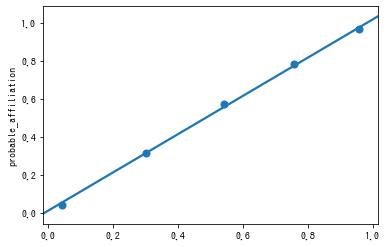

In [0]:
#plotting against actual values for training set
import seaborn as sns
sns.regplot(y_predprob_logit_train, y_train, x_bins=5)

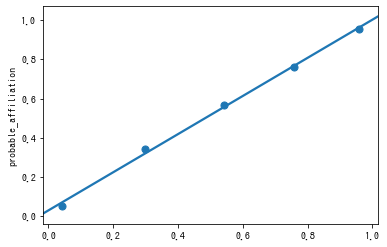

In [0]:
#plotting against actual values for test set
y_predprob_logit_test = y_predprob_logit_test[:,1].reshape(-1,1)
sns.regplot(y_predprob_logit_test, y_test, x_bins=5)